In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon, LineString, Point
import numpy as np
from shapely.ops import split,nearest_points

In [38]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [39]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

In [40]:
def make_graph(point_1, point_2, obstacles, path = False):
    plt.scatter(point_1[0], point_1[1], c="blue")
    plt.scatter(point_2[0], point_2[1], c="blue")
    plt.plot([point_1[0], point_2[0]],[point_1[1], point_2[1]], c="gray")
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
        
    if path:
        for i in range(len(path) - 1):
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],c="green")
    plt.grid(True)
    plt.show()

In [95]:
def create_polygon(obstacle):
    # corner_1 = obstacle[0]
    # corner_2 = obstacle[1]

    # coords = [[corner_1[0],corner_1[1]],[corner_2[0],corner_1[1]],[corner_2[0],corner_2[1]],[corner_1[0], corner_2[1]],[corner_1[0], corner_1[1]]]
    coords = []

    for obs in obstacle:
        coords.append(obs)

    obs_polygon = Polygon(coords)
    return obs_polygon


In [42]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [99]:
def dist(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

In [44]:
def create_shortest_path_1(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    for x in frange(0,6,0.5):
        for y in frange(0,6,0.5):
            flag = True
            point = (x, y)
            for obs_id, obs in obstacle_polygon.items():
                if Point(point).intersects(obs):
                    flag = False
                    break
            if flag:
                G.add_node(point)


    print(G.nodes())

    # Add edges between adjacent points (up, down, left, right)
    for node in G.nodes():
        x, y = node
        for dx, dy in [(0.5, 0), (-0.5, 0), (0, 0.5), (0, -0.5), (0.5, 0.5), (-0.5, -0.5), (-0.5, 0.5),(0.5, -0.5)]:
            neighbor = (x + dx, y + dy)
            if neighbor in G.nodes():
                G.add_edge(node, neighbor)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=dist)
    print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=dist))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

In [45]:
def check_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            if len((line.intersection(obs)).coords) == 1:
                print("allow",line.intersection(obs))
                return False
            else:
                return True
    return False

In [46]:
def create_shortest_path_2(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
    route_line = LineString([point_1, point_2])

    intersections = []
    for obstacle_id, obstacle in obstacle_polygon.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(start)
                intersections.append(end)
    print(intersections)
    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for i in range(len(intersections)):
        point = intersections[i]
        pt_1 = (point[0] + 0.1, point[1])
        pt_2 = (point[0] - 0.1, point[1])
        pt_3 = (point[0], point[1] - 0.1)
        pt_4 = (point[0], point[1] + 0.1)
        pts = [pt_1, pt_2, pt_3, pt_4]

        for pt in pts:
            flag = True
            for obs_id, obs in obstacle_polygon.items():
                if Point(pt[0], pt[1]).intersects(obs):
                    flag = False
                    break
            if flag:
                G.add_node(pt)
    
    G.add_node(tuple(point_2))

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            if not check_obstacle(cur, next, obstacle_polygon):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=dist)
    print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=dist))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

## Main

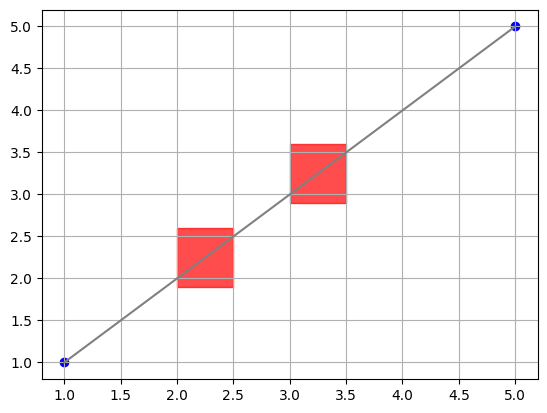

In [47]:
point_1 = [1,1]
point_2 = [5,5]

obstacles = {
    0 : [[2,1.9],[2.5,2.6]],
    1 : [[3,2.9],[3.5,3.6]]
}

make_graph(point_1, point_2, obstacles)

In [48]:
path_1 = create_shortest_path_1(point_1, point_2, obstacles)
make_graph(point_1, point_2, obstacles, path = path_1)

ValueError: A linearring requires at least 4 coordinates.

[(2.5, 1.9), (2.5, 2.6), (2.0, 2.6), (2.0, 1.9), (3.5, 2.9), (3.5, 3.6), (3.0, 3.6), (3.0, 2.9)]
Path cost : 3


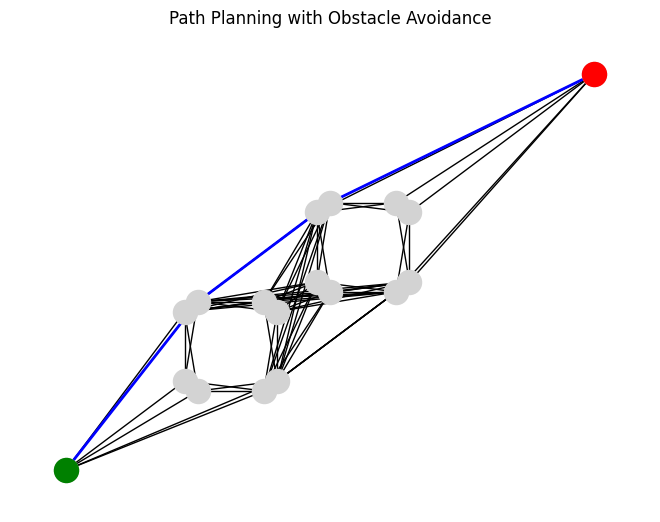

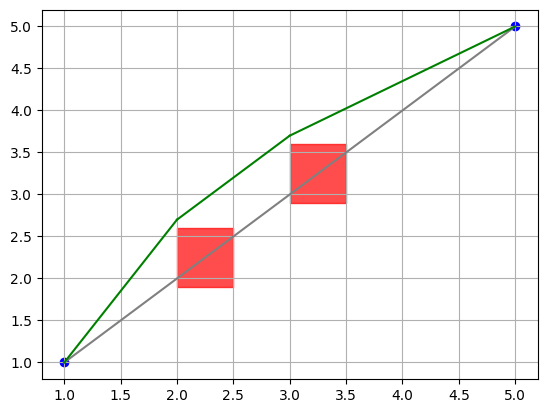

Distance 5.77189394308001


In [ ]:
path_2 = create_shortest_path_2(point_1, point_2, obstacles)
make_graph(point_1, point_2, obstacles, path = path_2)
print("Distance",total_dist(path_2))

[(2.5, 1.9), (2.5, 2.6), (2.0, 2.6), (2.0, 1.9), (3.5, 2.9), (3.5, 3.6), (3.0, 3.6), (3.0, 2.9)]
Path cost : 3


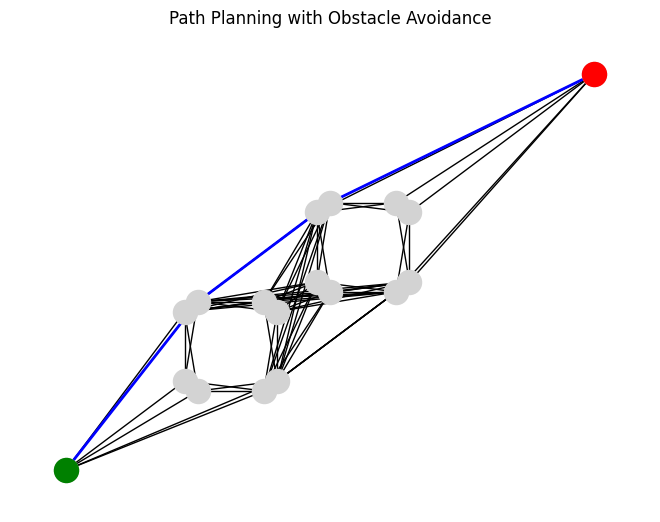

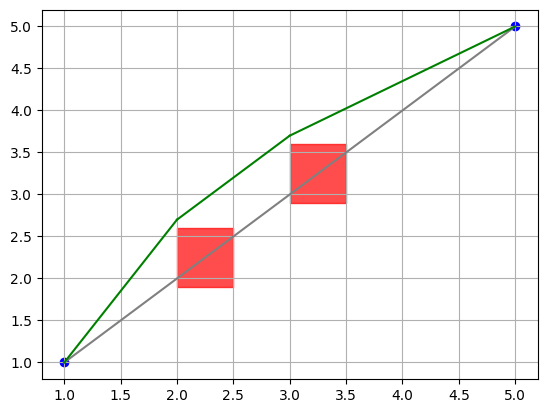

In [ ]:
path_3 = create_shortest_path_2(point_1, point_2, obstacles)
make_graph(point_1, point_2, obstacles, path = path_3)

## DP creation in cluster projects

In [ ]:
from k_means_constrained import KMeansConstrained
import numpy as np
import random

def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

In [ ]:
def create_dp(points):
    x = [i for i,j in points]
    y = [j for i,j in points]

    dp = [np.mean(x), np.mean(y)]

    return dp

In [ ]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc.append([loc_x,loc_y])
        
    return loc

In [ ]:
def clusters_plot(clusters, centroids, dp=False):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.title("After Clustering")
    plt.show()

In [ ]:
def dp_plot(clusters, centroids, dp):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        for i in range(len(points)-1):
            plt.plot([points[i][0],points[i+1][0]],[points[i][1], points[i+1][1]], c='gray')
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    if dp:
        plt.scatter(dp[0], dp[1], marker='X', c='red', s=200)
    plt.title("After Clustering")
    plt.show()

In [ ]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [ ]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += calculate_distance(pts[i], pts[i+1])

    return sum

In [ ]:
from itertools import permutations

def tsp(cluster):
    paths = list(permutations(cluster))
    distance = []
    for path in paths:
        path = list(path)
        dist = 0
        for i in range(len(path)-1):
            dist += calculate_distance(path[i], path[i+1])
        distance.append(dist)
    
    ans_route = paths[np.argmin(distance)]
    ans_distance = distance[np.argmin(distance)]

    return [ans_route[0], ans_route[-1]],ans_route

Main

In [ ]:
n = 20
k = 5

# creating the boundary
x = [22.5726, 88.4010]
y = [22.6141, 88.4654]
delivery_loc = create_locations(x, y, n)

centroids, clusters = KMeans(delivery_loc, n, k)

clusters

{0: [[22.585, 88.4291],
  [22.5779, 88.4162],
  [22.5913, 88.4265],
  [22.5735, 88.4136],
  [22.589199999999998, 88.4257]],
 1: [[22.61, 88.4548],
  [22.5788, 88.4644],
  [22.5977, 88.4549],
  [22.5914, 88.4614],
  [22.6098, 88.4568]],
 2: [[22.5737, 88.4335],
  [22.5781, 88.4322],
  [22.576999999999998, 88.4292],
  [22.5766, 88.4463],
  [22.5895, 88.4429]],
 3: [[22.6, 88.4024],
  [22.593, 88.4274],
  [22.5999, 88.4023],
  [22.6037, 88.4088],
  [22.603, 88.4039]]}

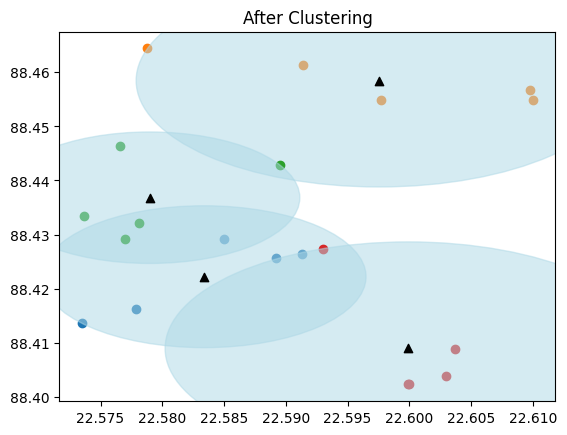

In [ ]:
clusters_plot(clusters, centroids)

In [ ]:
longest_points = []

for cls_id, cluster in clusters.items():
    points, new_cluster = tsp(cluster)
    clusters[cls_id] = new_cluster
    longest_points.append(points[0])
    longest_points.append(points[1])

print(clusters)
print(longest_points)

{0: ([22.5735, 88.4136], [22.5779, 88.4162], [22.585, 88.4291], [22.589199999999998, 88.4257], [22.5913, 88.4265]), 1: ([22.61, 88.4548], [22.6098, 88.4568], [22.5977, 88.4549], [22.5914, 88.4614], [22.5788, 88.4644]), 2: ([22.576999999999998, 88.4292], [22.5781, 88.4322], [22.5737, 88.4335], [22.5766, 88.4463], [22.5895, 88.4429]), 3: ([22.593, 88.4274], [22.6037, 88.4088], [22.603, 88.4039], [22.6, 88.4024], [22.5999, 88.4023])}
[[22.5735, 88.4136], [22.5913, 88.4265], [22.61, 88.4548], [22.5788, 88.4644], [22.576999999999998, 88.4292], [22.5895, 88.4429], [22.593, 88.4274], [22.5999, 88.4023]]


In [ ]:
dp = create_dp(longest_points)
print(dp)

[22.589125, 88.4326375]


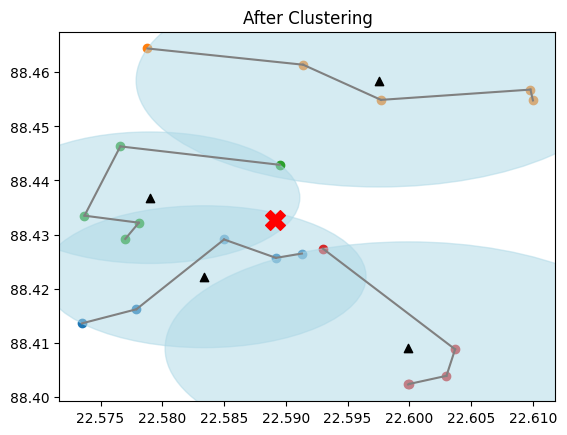

In [ ]:
dp_plot(clusters, centroids, dp)

In [ ]:
# final path

for cls_id, cluster_path in clusters.items():
    path = list(cluster_path)
    path.append(dp)
    path.insert(0, dp)
    clusters[cls_id] = path

print(clusters)

{0: [[22.589125, 88.4326375], [22.5735, 88.4136], [22.5779, 88.4162], [22.585, 88.4291], [22.589199999999998, 88.4257], [22.5913, 88.4265], [22.589125, 88.4326375]], 1: [[22.589125, 88.4326375], [22.61, 88.4548], [22.6098, 88.4568], [22.5977, 88.4549], [22.5914, 88.4614], [22.5788, 88.4644], [22.589125, 88.4326375]], 2: [[22.589125, 88.4326375], [22.576999999999998, 88.4292], [22.5781, 88.4322], [22.5737, 88.4335], [22.5766, 88.4463], [22.5895, 88.4429], [22.589125, 88.4326375]], 3: [[22.589125, 88.4326375], [22.593, 88.4274], [22.6037, 88.4088], [22.603, 88.4039], [22.6, 88.4024], [22.5999, 88.4023], [22.589125, 88.4326375]]}


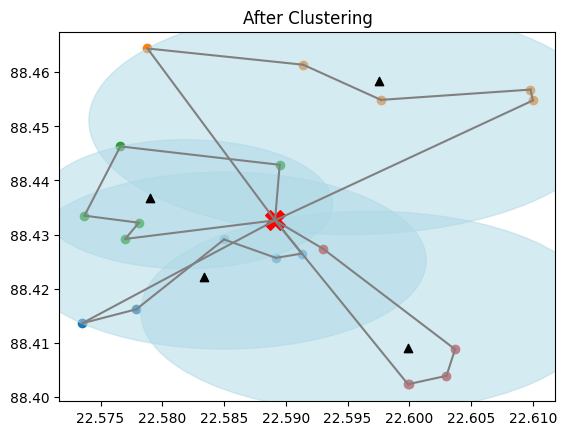

In [ ]:
dp_plot(clusters, centroids, dp)

In [ ]:
total_distance = 0

for cls_id, cluster_path in clusters.items():
    distance = total_dist(cluster_path)
    total_distance += distance

print("Total distance :", total_distance)

Total distance : 0.28446653249841775


## Curve line project

In [91]:
from shapelysmooth import catmull_rom_smooth

In [90]:
from shapely.affinity import translate
from shapely.geometry import MultiLineString

In [89]:
def scale_polygon(polygon, scale_factor = 0.9):
    centroid = polygon.centroid

    print("Points ",points)

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [104]:
def line_intersect(line, obstacle):
    points = line.intersection(obstacle)
    
    if(type(points) != Point and type(points) != LineString):
        return True
    
    if len(points.coords) == 0 or len(points.coords) == 1:
        return False

    points = [pt for pt in points.coords]
    obstacle_points = [pt for pt in obstacle.exterior.coords[:-1]]

    try :
        index_list = [obstacle_points.index(i) for i in points]
    except:
        return True

    for i in range(0,len(index_list)-1,2):
        if not (abs(index_list[i] - index_list[i+1]) == 1 or abs(index_list[i] - index_list[i+1]) == len(obstacle_points)-1):
            return True

    return False

In [87]:
def check_for_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        if line_intersect(line,obs):
            # if len((line.intersection(obs)).coords) > 1:
            return True
    return False

In [86]:
def create_shortest_path_3(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
    route_line = LineString([point_1, point_2])

    print("Initial polygon ",obstacle_polygon)

    intersections = []
    for obstacle_id, obstacle in obstacle_polygon.items():
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])
    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))

    G.add_node(tuple(point_2))
    
    # create new polygon
    # for obs_id, obstacle in obstacle_polygon.items():
    #     obstacle_polygon[obs_id] = scale_polygon(obstacle)
    
    # print("New polygon ",obstacle_polygon)

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            if not check_for_obstacle(cur, next, obstacle_polygon):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=dist)
    print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=dist))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

In [93]:
def create_shortest_path_curve(path):
    print(path)
    answer = catmull_rom_smooth(LineString(path), 0.5, 10).coords
    print(answer)
    return answer

Initial polygon  {2: <POLYGON ((2 2, 6 2, 6 4, 4 4, 4 6, 6 6, 6 8, 2 8, 2 2))>}
POINT (2 2)
POINT (6 2)
LINESTRING (2.666666666666667 2, 6 4)
LINESTRING (2 2, 4 4)
LINESTRING (2 2.666666666666667, 4 6)
GEOMETRYCOLLECTION (LINESTRING (2 2, 4 4), POINT (6 6))
MULTILINESTRING ((2 2.4, 4 5.2), (4.571428571428571 6, 6 8))
POINT (2 8)
LINESTRING (2 2, 4 4)
POINT (2 2)
LINESTRING (2 2, 6 2)
LINESTRING (2 2, 6 4)
LINESTRING (2 2, 4 4)
LINESTRING (2 2, 4 6)
GEOMETRYCOLLECTION (LINESTRING (2 2, 4 4), POINT (6 6))
MULTILINESTRING ((2 2, 4 5), (4.666666666666667 6, 6 8))
LINESTRING (2 2, 2 8)
LINESTRING (2 2, 4 4)
POINT (6 2)
LINESTRING (6 2, 2 2)
LINESTRING (6 2, 6 4)
LINESTRING (6 2, 4 4)
GEOMETRYCOLLECTION (LINESTRING (6 2, 5 4), POINT (4 6))
GEOMETRYCOLLECTION (LINESTRING (6 2, 6 4), POINT (6 6))
MULTILINESTRING ((6 2, 6 4), (6 6, 6 8))
MULTILINESTRING ((6 2, 4.666666666666667 4), (4 5, 2 8))
LINESTRING (6 2, 5.333333333333333 4)
LINESTRING (6 4, 2.666666666666667 2)
LINESTRING (6 4, 2 2)
LINE

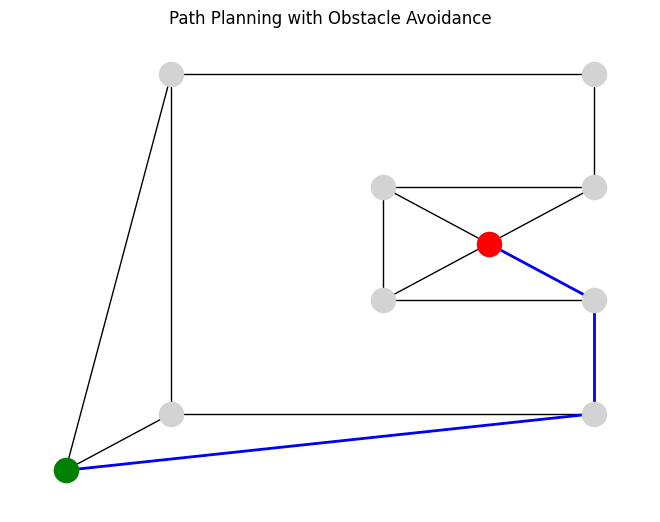

[(1, 1), (6.0, 2.0), (6.0, 4.0), (5, 5)]


In [108]:
point_1 = [1,1]
point_2 = [5,5]

obstacles = {
    # 0 : [[2,2],[2.5,2.0],[2.5, 2.5], [2.0,2.5],[2,2]],
    # 1 : [[3.0,3.0],[3.5,3.0],[3.5, 3.5],[3.25, 3.75],[3.0, 3.5],[3.0, 3.0]],
    2 : [(2,2),(6,2),(6,4),(4,4),(4,6),(6,6),(6,8),(2,8),(2,2)]
}
path = create_shortest_path_3(point_1, point_2, obstacles)
path_2 = create_shortest_path_curve(path)
# make_graph(point_1, point_2, obstacles, path)
# make_graph(point_1, point_2, obstacles, path_2)
# print("Distance in line :",total_dist(path))
# print("Distance in curve :",total_dist(path_2))

In [ ]:
coords = [[3.0,3.0],[3.5,3.0],[3.5, 3.5],[3.25, 3.75],[3.0, 3.5],[3.0, 3.0]]

sample = Polygon(coords)

boundary = sample.exterior.coords

boundary[0][0] - 0.1

2.9

In [ ]:
coords = [[2,2],[4,2],[4,4],[2,4],[2,2]]
obs = Polygon(coords)
line = LineString([[2,2],[4,4]])

line.crosses(obs)

False

In [53]:
from shapely.affinity import translate

# Define the original points of the polygon
points = [[2,2],[2.5,2.0],[2.5, 2.5], [2.0,2.5],[2,2]]

# Create a Shapely polygon object
polygon = Polygon(points)

# Find the centroid of the polygon
centroid = polygon.centroid

# Define the scale factor to reduce the distance
scale_factor = 0.9  # You can adjust this value to control the reduction

# Create a new polygon with reduced distance from the centroid
new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in points]
new_polygon = Polygon(new_points)

print("Original polygon:", polygon)
print("New polygon:", new_polygon)

Original polygon: POLYGON ((2 2, 2.5 2, 2.5 2.5, 2 2.5, 2 2))
New polygon: POLYGON ((2.025 2.025, 2.475 2.025, 2.475 2.475, 2.025 2.475, 2.025 2.025))


In [71]:
for i in polygon.exterior.coords:
    print(i)

(2.0, 2.0)
(2.5, 2.0)
(2.5, 2.5)
(2.0, 2.5)
(2.0, 2.0)


TSP

[(2, 2), (7, 3)]


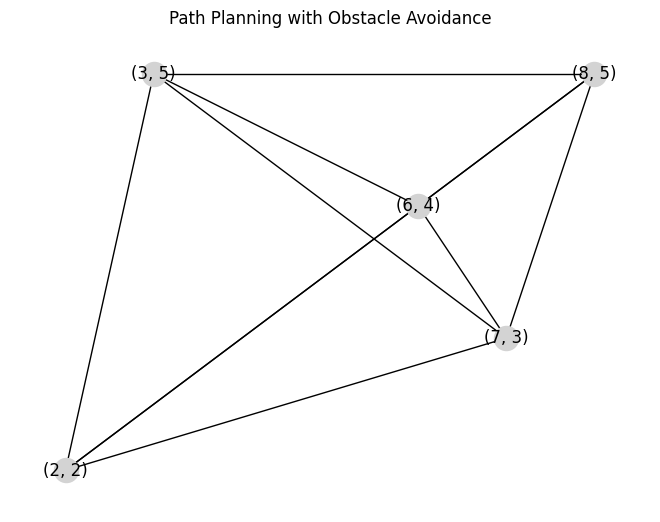

In [16]:
points = [(2,2),(3,5),(6,4),(8,5),(7,3)]
G = nx.Graph()
for pt in points:
    G.add_node(pt)

for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        G.add_edge(points[i],points[j])

path = nx.dijkstra_path(G,(2,2),(7,3))
print(path)

pos = {node: node for node in G.nodes()}
nx.draw(G, pos, node_color='lightgray', with_labels=True)
# nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
# nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
# nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
plt.title('Path Planning with Obstacle Avoidance')
plt.show()

Test

In [1]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely.ops import split

In [2]:
def line_intersect(line, obstacle):
    points = line.intersection(obstacle)
    
    if(type(points) == MultiLineString):
        return True
    
    if len(points.coords) == 0 or len(points.coords) == 1:
        return False

    points = [pt for pt in points.coords]
    obstacle_points = [pt for pt in obstacle.exterior.coords[:-1]]

    try :
        index_list = [obstacle_points.index(i) for i in points]
    except:
        return True

    for i in range(0,len(index_list)-1,2):
        if not (abs(index_list[i] - index_list[i+1]) == 1 or abs(index_list[i] - index_list[i+1]) == len(obstacle_points)-1):
            return True

    return False

In [20]:
def line_intersect_2(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [22]:
coords = [(2,2),(6,2),(6,4),(4,4),(4,6),(6,6),(6,8),(2,8),(2,2)]
obstacle = Polygon(coords)

line_1 = LineString([(2,1),(2,8)])
line_2 = LineString([(1,2),(8,2)])
line_3 = LineString([(6,1),(6,9)])
line_4 = LineString([(1,3),(9,3)])
line_5 = LineString([(1,1),(8,1)])

print(line_intersect(line_1, obstacle))
print(line_intersect(line_2, obstacle))
print(line_intersect(line_3, obstacle))
print(line_intersect(line_4, obstacle))
print(line_intersect(line_5, obstacle))

print('-'*50)

print(line_intersect_2(line_1, obstacle))
print(line_intersect_2(line_2, obstacle))
print(line_intersect_2(line_3, obstacle))
print(line_intersect_2(line_4, obstacle))
print(line_intersect_2(line_5, obstacle))

False
False
True
True
False
--------------------------------------------------
False
False
False
True
False


In [19]:
area = obstacle.area

parts_1 = split(obstacle, line_1)
parts_2 = split(obstacle, line_2)
parts_3 = split(obstacle, line_3)
parts_4 = split(obstacle, line_4)
parts_5 = split(obstacle, line_5)

print(area)
print(parts_1)
print(parts_2)
print(len([geoms for geoms in parts_3.geoms]))
print(len([geoms for geoms in parts_4.geoms]))
print(parts_5)

20.0
GEOMETRYCOLLECTION (POLYGON ((2 8, 6 8, 6 6, 4 6, 4 4, 6 4, 6 2, 2 2, 2 8)))
GEOMETRYCOLLECTION (POLYGON ((6 2, 2 2, 2 8, 6 8, 6 6, 4 6, 4 4, 6 4, 6 2)))
1
2
GEOMETRYCOLLECTION (POLYGON ((2 2, 2 8, 6 8, 6 6, 4 6, 4 4, 6 4, 6 2, 2 2)))


In [72]:
num = 10

type(num) == int

True

DP Relocation    

In [3]:
coords = [(2,2),(6,2),(6,6),(2,6),(2,2)]
polygon = Polygon(coords)
point = Point(5,3)

In [4]:
polygon.contains(point)

True

In [5]:
nearest_pt = nearest_points(polygon.exterior,point)

nearest_pt = nearest_pt[0].coords[0]

nearest_pt

(5.0, 2.0)